In [1]:
import tensorflow as tf
import gzip
import numpy as np

# Dataset

The dataset that is going to be used in this notebook the fashion MNIST dataset that we'll load from tensorflow. The following dictionary will help us understand the clothing categories corresponding to the integer labels. 

In [2]:
labels_map = {
    0: 'T-shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot'
}

In [3]:
# Loading the dataset
(training_images, training_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


Let's display a sampling of images and corresponding labels from training data

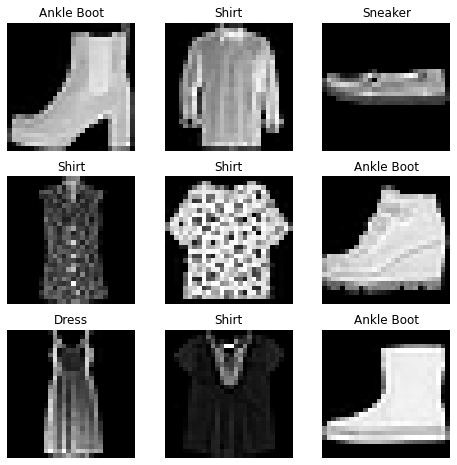

In [14]:
import random
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(8, 8))
cols = 3
rows = 3

for i in range(1, cols * rows + 1):
    sample_idx = random.randint(0, len(training_images))
    image = training_images[sample_idx]
    label = training_labels[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(image.squeeze(), cmap='gray')
plt.show()

For large datasets, we'll need to wrap the dataset in tf.data.Dataset instance which handles large data better by making it easy to keep just a portion of it in memory. Let's use this in this notebook even if our dataset is small

In [16]:
train_dataset = tf.data.Dataset.from_tensor_slices((training_images, training_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

Each pixel of the image is represented by an unsigned int. In machine learning, we generally want the pixel values of our training data to be floating-point 0 and 1, so we convert them in the following way

In [17]:
train_dataset = train_dataset.map(lambda image, label: (float(image) / 255.0, label))
test_dataset = test_dataset.map(lambda image, label: (float(image) / 255.0, label))

Let's inspect the values of our dataset to see the changes made

In [22]:
train_dataset.as_numpy_iterator().next()[0]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.    

Let's get batches of data of size 64 and shuffle the data

In [23]:
batch_size = 64
train_dataset = train_dataset.batch(batch_size).shuffle(500)
test_dataset = test_dataset.batch(batch_size).shuffle(500)

In [24]:
len(train_dataset.as_numpy_iterator().next()[0])

64

# Neural network architecture

Our goal is to classify an input image into one of the 10 classes of clothing, so we'll define a neural network to take as input matrix of shape (28, 28) and output a vector of size 10, where the index of the largest value in the output corresponds to the integer label for the class of clothing in the image. 

Since each image has 28 x 28 = 784 pixels, we need 784 nodes in the input layer. We decided to add one hidden layer with 20 nodes and a ReLU (rectified linear unit) activation function. We want the output of our network to be a vector of size 10, therefore our output layer needs to have 10 nodes

In [26]:
class NeuralNetwork(tf.keras.Model):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.sequence = tf.keras.Sequential([
            # Flatten layers turns our input into a vector of size 784
            tf.keras.layers.Flatten(input_shape=(28, 28)),
            # Dense layers (fully connected) layers because they connect all nodes from
            # the previous layer with each of their own nodes using a linear function.
            # The ReLU adds non-linearity to the calculations
            tf.keras.layers.Dense(20, activation='relu'),
            tf.keras.layers.Dense(10)
        ])

    # This method supplies a tensor x as input to the sequence of layers
    # and produces the y_prime vector as a result
    def call(self, x: tf.Tensor) -> tf.Tensor:
        y_prime = self.sequence(x)
        return y_prime

In [27]:
model = NeuralNetwork()
model.build((1, 28, 28))
model.summary()

Model: "neural_network"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 10)                15910     
Total params: 15,910
Trainable params: 15,910
Non-trainable params: 0
_________________________________________________________________


# Training and Evaluation

In [28]:
learning_rate = 0.1

# from_logits=True normalize the inputs to get a probability distribution
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.SGD(learning_rate)
metrics = ['accuracy']

model.compile(optimizer, loss_fn, metrics)

In [30]:
epochs = 5
print('\nFitting')
model.fit(train_dataset, epochs=epochs)


Fitting
Epoch 1/5
938/938 [==============================] - 24s 16ms/step - loss: 0.6334 - accuracy: 0.7785
Epoch 2/5
938/938 [==============================] - 17s 15ms/step - loss: 0.4526 - accuracy: 0.8403
Epoch 3/5
938/938 [==============================] - 17s 15ms/step - loss: 0.4156 - accuracy: 0.85180s - loss: 0.4159 - accu
Epoch 4/5
938/938 [==============================] - 17s 16ms/step - loss: 0.3917 - accuracy: 0.8603
Epoch 5/5
938/938 [==============================] - 16s 15ms/step - loss: 0.3771 - accuracy: 0.8641


We got a pretty good score at the training so let's now evaluate our model on the test dataset.

In [31]:
print('\nEvaluating')
(test_loss, test_accuracy) = model.evaluate(test_dataset)
print(f"\nTest accuracy {test_accuracy * 100:>0.1f}%, test loss : {test_loss:>8f}")


Evaluating
157/157 [==============================] - 3s 8ms/step - loss: 0.4345 - accuracy: 0.8447

Test accuracy 84.5%, test loss : 0.434483


The model performs well on the test. Let's save the model

In [32]:
model.save('fashion_mnist_model')

INFO:tensorflow:Assets written to: fashion_mnist_model\assets


# Prediction

For the prediction, we can load the saved model by using `tf.keras.models.load_model` but since it's already available, we'll use it to make some prediction

In [34]:
from PIL import Image
import requests

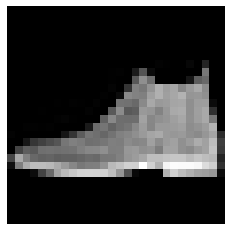

In [35]:
url = 'https://raw.githubusercontent.com/MicrosoftDocs/tensorflow-learning-path/main/intro-keras/predict-image.png'

with Image.open(requests.get(url, stream=True).raw) as image:
    X = np.asarray(image, dtype=np.float32).reshape((-1, 28, 28)) / 255.0
    
    plt.figure()
    plt.axis('off')
    plt.imshow(X.squeeze(), cmap='gray')
    plt.show()

In [37]:
predicted_vector = model.predict(X)
predicted_index = np.argmax(predicted_vector)
predicted_name = labels_map[predicted_index]

print(f"Predicted class : {predicted_name}")

Predicted class : Ankle Boot
